# 月线多头

寻找月线多头

In [5]:
from alpha.notebook import *

await init_notebook(use_omicron=False)
def load_monthly_bars():
    with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
        return pickle.load(f)

In [2]:
def scan(end:str=None):
    """通过月均线预测下一个月涨幅"""
    if end is None:
        end = arrow.now().date()
    else:
        end = arrow.get(end).date()
        
    results = []
    nbars = 29
    for i, code in enumerate(choose_stocks(50, 1000)):
        name = get_name(code)
        bars = get_bars(code, nbars, end, unit='1M')
        
        if len(bars) < nbars:
            continue
            
        close = bars["close"]
        c0 = close[-1]
        max_pcr = 0
        
        mas = []
        for win in [5, 10, 20]:
            ma = moving_average(close, win)[-1]
            mas.append(ma)
            
            ypreds, pmae = predict_by_moving_average(close, win, n=10)
            if ypreds is None:
                continue
                
            pcr = max(ypreds) / c0 - 1
            max_pcr = max(pcr, max_pcr)
        
        if max_pcr < 0.1:
            continue
            
        if mas[0] >= mas[1] >= mas[2]:
            row = [name, code, max_pcr]
            row.extend(mas)
            results.append(row)

    return pd.DataFrame(results, columns=["股票", "代码", "预测涨幅", "ma5", "ma10", "ma20"])

In [ ]:
df = scan()
df.style.format({
    "预测涨幅": "{:.0%}"
})

In [ ]:
df.sort_values("预测涨幅", ascending=False)

# 相似均线拟合法

In [35]:
# 给定时间点和代码，生成拟合均线。再scan所有股票和所有时间点，将欧氏距离和实际涨幅分别作为x,y

def build_sample_line(code, frame:str, ma_groups=(5, 10, 20)):
    line_len = 7
    nbars = max(ma_groups) + line_len - 1
    bars = get_bars(code, nbars, frame, unit="1M")
    
    x = np.arange(line_len)
    
    vec = []
    dist = {}
    for win in ma_groups:
        ma = moving_average(bars["close"], win)[-line_len:]
        ma /= ma[0]
        coeff, pmae = polyfit(ma)
        vec.append(np.polyval(coeff, x))
        
    return vec

jl = build_sample_line("002791.XSHE", "2019-12-31")
jl

[array([1.01196081, 1.03484548, 1.08812264, 1.17179228, 1.28585442,
        1.43030903, 1.60515614]),
 array([0.99989306, 1.04790797, 1.11745669, 1.20853923, 1.3211556 ,
        1.45530578, 1.61098979]),
 array([1.00294756, 0.98767367, 0.98656675, 0.99962678, 1.02685378,
        1.06824775, 1.12380868])]

## 坚朗五金月线拟合

In [46]:
def search_jl(sample_lines, line_len=7, ma_groups=(5, 10, 20)):
    nbars = max(ma_groups) + line_len - 1
    results = []
    
    x = np.arange(line_len)
    threshold = {
        5: 0.03,
        10: 0.025,
        20:0.01
    }
    for code, bars in load_monthly_bars().items():
        for i in range(nbars, len(bars) - 1):
            bars_ = bars[i-nbars: i]
            
            frame = bars_['date'][-1]
            close = bars_['close']
            
            c0 = close[-1]
            c1 = bars["close"][i]
            
            pcr = c1/c0 - 1

            row = [code, get_name(code), frame, pcr]
            mas = []
            for win in ma_groups:
                ma = moving_average(close, win)[-line_len:]
                ma /= ma[0]
                mas.append(ma)

            
            distances = paired_distances(sample_lines, mas)
            row.extend(distances)

            results.append(row)
            
    return pd.DataFrame(results, columns=["code", "name", "frame", "pcr", "d5", "d10", "d20"])

jl = build_sample_line("002791.XSHE", "2019-12-31")
df_jl = search_jl(jl)
df_jl

,code,name,frame,pcr,d5,d10,d20
0,000001.XSHE,平安银行,2018-02-28,-0.095986,0.332007,0.535052,0.120371
1,000001.XSHE,平安银行,2018-03-30,-0.004826,0.412514,0.512053,0.135537
2,000001.XSHE,平安银行,2018-04-27,-0.061106,0.541735,0.524748,0.136592
3,000001.XSHE,平安银行,2018-05-31,-0.107438,0.738338,0.594178,0.122654
4,000001.XSHE,平安银行,2018-06-29,0.052083,0.920721,0.679874,0.111317
...,...,...,...,...,...,...,...
134047,603999.XSHG,读者传媒,2021-02-26,0.007874,0.937810,1.009788,0.149231
134048,603999.XSHG,读者传媒,2021-03-31,-0.015625,0.993823,1.014437,0.163885
134049,603999.XSHG,读者传媒,2021-04-30,0.132937,1.052503,0.983871,0.166475
134050,603999.XSHG,读者传媒,2021-05-31,-0.085814,1.109284,0.968252,0.168404


In [47]:
df_jl[df_jl.d5<0.05]

,code,name,frame,pcr,d5,d10,d20
2866,000157.XSHE,中联重科,2021-03-31,-0.071020,0.047535,0.281168,0.326099
10908,000708.XSHE,中信特钢,2019-12-31,-0.067877,0.034391,0.120660,0.187678
12064,000748.XSHE,长城信息,2015-02-27,0.144368,0.049932,0.249988,0.683716
21589,002050.XSHE,三花智控,2020-02-28,-0.191304,0.044134,0.396129,0.047266
32255,002311.XSHE,海大集团,2020-08-31,-0.133390,0.045720,0.350900,0.358054
33452,002340.XSHE,格林美,2021-04-30,0.126126,0.042371,0.430425,0.136470
33937,002352.XSHE,顺丰控股,2020-09-30,0.019681,0.033829,0.348838,0.153156
40454,002511.XSHE,中顺洁柔,2020-07-31,0.004523,0.027499,0.370781,0.310090
51561,002791.XSHE,坚朗五金,2019-12-31,0.372652,0.028337,0.022275,0.008794
53959,002880.XSHE,卫光生物,2020-07-31,-0.154772,0.028257,0.275153,0.193937


## 鸿路钢构

In [ ]:
mas_hl = {}

hl = get_bars('002541.XSHE', 29, '2020-01-23', unit='1M')
print(bars['date'][-3:])
for win in [5, 10, 20]:
    ma = moving_average(bars['close'], win)[-10:]
    ma /= ma[0]
    coeff, pmae = polyfit(ma)
    
    fitma = np.polyval(coeff, x)
    mas_hl[win] = fitma
mas_hl

In [ ]:
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances

x = np.arange(10)

colors = {
    5: 'r',
    10:'g',
    20:'blue'
}
for win in [5, 10, 20]:
    ma_hl = mas_hl[win]
    ma_jl = mas_jl[win]
    
    d = euclidean_distances([ma_hl], [ma_jl])
    print(d)
    
    plt.plot(x, ma_hl, ".", color=colors[win])
    plt.plot(x, ma_jl, "-", color=colors[win])

In [ ]:
secs[secs.start_date < datetime.datetime(2018,1,1,0,0,0)]

# 机器学习方法

In [2]:
import pickle
def make_ds_month(path):
    end = arrow.get("2021-08-31").date()
    data = {}
    for code in secs[secs.start_date < datetime.datetime(2018,1,1,0,0,0)].index:
        bars = get_bars(code, 68, end, unit='1M')
        data[code] = bars
        
    path = os.path.expanduser(path)
    with open(path, "wb") as f:
        pickle.dump(data, f, protocol=5)

In [3]:
   
def search():
    results = []
    pred_samples = {
        5: 7,
        10: 10,
        20: 10
    }
    for code, bars in load_monthly_bars().items():
        for i in range(29, len(bars) - 1):
            bars_ = bars[i-29: i]
            
            frame = bars_['date'][-1]
            c0 = bars_['close'][-1]
            c1 = bars[i]['close']
            pcr = c1/c0 - 1

            row = [code, get_name(code), frame, pcr]
            for win in [5, 10, 20]:
                ma = moving_average(bars_['close'], win)[-10:]
                ma /= ma[0]
                (a,b,c), pmae = polyfit(ma)
                
                ypreds, _ = predict_by_moving_average(bars_['close'], win, 1, 1, pred_samples[win])
                if ypreds is not None:
                    pred = ypreds[0] / c0 - 1
                else:
                    pred = None
                    
                row.extend((a, b, pmae, pred))

            results.append(row)
                        
    return pd.DataFrame(results, columns=["code", "name", "frame", "actual", "a5", "b5", "pmae5", "pred5",
                                         "a10", "b10", "pmae10", "pred10",
                                         "a20", "b20", "pmae20", "pred20"])
            
df = search()

In [4]:
def preprocess(df):
    """prepare dataset for xgboost classification
    
    0 不可预测
    1 可用5月线预测
    2 可用10月线
    3 可用20月线
    """
    return {
        "X": df[["a5", "b5", "pmae5", "pred5",
                "a10", "b10", "pmae10", "pred10",
                "a20", "b20", "pmae20", "pred20"]],
        
        "y": labelling(df)
    }


In [5]:
def labelling(df, threshold=0.1):
    """"""
    labels = []
    for i in range(len(df)):
        pred5 = df.loc[i, "pred5"]
        pred10 = df.loc[i, "pred10"]
        pred20 = df.loc[i, "pred20"]
        actual = df.loc[i, "actual"]
        
        d = np.abs(np.array([pred5 - actual, pred10 - actual, pred20 - actual]))
        if min(d) > threshold:
            labels.append(0)
            continue
            
        pos = np.argmin(d)
        labels.append(pos + 1)
        
    return labels

In [ ]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform


def train(X_train, y_train, X_test, y_test):
    model = XGBClassifier()
    
    params = {
            "colsample_bytree": uniform(0.7, 0.3),
            "gamma": uniform(0, 0.5),
            "learning_rate": uniform(0.01, 1),
            "max_depth": randint(2, 6),
            "n_estimators": randint(80, 150),
            "subsample": uniform(0.6, 0.4),
        }
    
    search = RandomizedSearchCV(
        model,
        param_distributions=params,
        random_state=78,
        n_iter=200,
        cv=10,
        verbose=1,
        n_jobs=1,
        return_train_score=True,
        refit=True,  # do the refit oursel
    )
    
    fit_params = {
            "eval_set": [(X_test, y_test)],
            "early_stopping_rounds": 5,
        }
    
    search.fit(X_train, y_train, **fit_params)
    
    best_model = search.best_estimator_
    preds = best_model.predict(X_test)
    report = classification_report(y_test, preds)
    print(report)
    
data = preprocess(df)
X, y = shuffle(data["X"], data["y"], random_state=78)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
train(X_train, y_train, X_test, y_test)

# 拟合均线预测法

在a5, a10, a20, a30都大于0的情况下，预测下一个月的涨幅。当拟合线与实际ma误差小于0.01时，认为拟合有效。

In [48]:
class NotFitableError(Exception):
    pass

class NotProfitableError(Exception):
    pass

def scan(fit_err=0.01):
    with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
        data = pickle.load(f)
        
    results = []
    for code, bars in data.items():
        name = get_name(code)
        
        for i in range(39, len(bars)-2):
            frame = bars["date"][i-1]
            close = bars["close"][i - 39: i]
            pcr = max(bars["close"][i:i+2])/close[-1] - 1
            max_pcr_pred = 0

            row = [name, code, frame, pcr]
            try:
                for win in [5, 10, 20, 30]:
                    fit_win = 7 if win == 5 else 10
                    ma = moving_average(close, win)[-fit_win:]
                    ma /= ma[0]
                            
                    coeff, pmae = polyfit(ma)
                    a, b, _ = coeff
                    
                    row.extend((a, b))
                    ma_fit = np.polyval(coeff, np.arange(fit_win))
                    d = euclidean_distances([ma_fit], [ma]).flatten()[0]
                    
                    if d > fit_err: # 当前均线没有指示意义
                        continue
                    
                    ypreds, _ = predict_by_moving_average(close, win, 2, err_threshold=1, n=fit_win)
                    if ypreds is not None:
                        pcr_pred = ypreds[-1] / close[-1] - 1
                        # 如果当前均线指示会有较大跌幅
                        if pcr_pred < 0 and abs(pcr_pred) > max(max_pcr_pred, 0.2):
                            raise NotProfitableError
                            
                        max_pcr_pred = max(max_pcr_pred, pcr_pred)
                        
                row.append(max_pcr_pred)
                results.append(row)
            except (NotFitableError, NotProfitableError):
                pass
            
    return pd.DataFrame(results, columns=["name", "code", "frame", "pcr", "a5", "b5", 
                                          "a10", "b10", "a20", "b20", "a30", "b30", "pred"])
        

In [49]:
df = scan(0.005)
df

,name,code,frame,pcr,a5,b5,a10,b10,a20,b20,a30,b30,pred
0,平安银行,000001.XSHE,2019-03-29,0.080841,0.001589,0.010246,0.002157,-0.030928,0.000464,0.003837,0.000148,0.006306,0.000000
1,平安银行,000001.XSHE,2019-04-30,0.005236,0.004915,-0.002852,0.003967,-0.041288,0.000450,0.005044,0.000409,0.004807,0.000000
2,平安银行,000001.XSHE,2019-05-31,0.171769,0.006446,-0.004358,0.004961,-0.043349,0.000362,0.006196,0.000576,0.003899,0.000000
3,平安银行,000001.XSHE,2019-06-28,0.027530,0.004595,0.016754,0.005082,-0.036298,0.000332,0.006782,0.000744,0.003336,0.000000
4,平安银行,000001.XSHE,2019-07-31,0.103774,0.001420,0.039597,0.004232,-0.020538,0.000082,0.009125,0.000819,0.003902,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79849,读者传媒,603999.XSHG,2021-01-29,0.019920,-0.008087,0.043065,-0.002601,0.018671,-0.001311,0.018172,0.000297,-0.008336,0.000000
79850,读者传媒,603999.XSHG,2021-02-26,0.007874,-0.006086,0.019196,-0.002085,0.010938,-0.001599,0.018723,0.000201,-0.006779,0.000000
79851,读者传媒,603999.XSHG,2021-03-31,0.115234,-0.003325,-0.003286,-0.001095,-0.000508,-0.001392,0.014552,0.000274,-0.006816,0.000000
79852,读者传媒,603999.XSHG,2021-04-30,0.132937,-0.000952,-0.023100,0.000042,-0.012780,-0.000917,0.007973,0.000475,-0.007959,0.000000


In [50]:
pred = df[df.pred!=0]
pred["gap"] = pred.pred - pred.pcr

/var/folders/b5/73vzvtdn4pn_8wt6rpd2tb_w0000gn/T/ipykernel_92887/3240071474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred["gap"] = pred.pred - pred.pcr


In [52]:
pred.gap.describe()

count    5793.000000
mean        0.119829
std         0.201467
min        -2.131919
25%         0.029443
50%         0.120081
75%         0.223297
max         1.495250
Name: gap, dtype: float64

In [487]:
pd.set_option('display.max_rows', 500)
pred[(pred.code=="000422.XSHE")]

,name,code,frame,pcr,a5,b5,a10,b10,a20,b20,a30,b30,pred,gap
2343,湖北宜化,000422.XSHE,2019-11-29,0.050725,0.001076,-0.052717,-0.004565,0.053913,0.002297,-0.041769,-0.000050,-0.027675,0.581643,0.530919
2344,湖北宜化,000422.XSHE,2019-12-31,-0.058621,0.007428,-0.086234,-0.003121,0.031028,0.002534,-0.039848,0.000682,-0.034634,0.627796,0.686417
2345,湖北宜化,000422.XSHE,2020-01-23,-0.036630,0.009162,-0.085617,-0.002885,0.020433,0.002655,-0.036466,0.000813,-0.035976,0.823688,0.860318
2355,湖北宜化,000422.XSHE,2020-11-30,0.081081,0.002627,-0.014833,0.001056,-0.019601,-0.001028,0.001572,0.002182,-0.031480,0.474015,0.392934
2356,湖北宜化,000422.XSHE,2020-12-31,0.171875,0.005125,-0.020424,0.001514,-0.020096,-0.001167,0.001052,0.002201,-0.027292,0.475655,0.303780


# 湖北宜化相似曲线方法

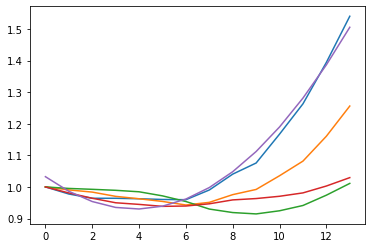

In [92]:
import matplotlib.pyplot as plt

lines = []

# till 2021-05-31
hbyh = data["000422.XSHE"][:-3]
for win in [5, 10, 20, 30]:
    line = moving_average(hbyh["close"], win)[-14:]
    line /= line[0]
    lines.append(line.tolist())
    
hbyh_vec = np.array(lines, dtype=np.float32)
for vec in hbyh_vec:
    plt.plot(vec)
    
coeff, pmae = polyfit(lines[0])
yfit = np.polyval(coeff, np.arange(0, 14))
plt.plot(yfit)

In [101]:
class NotEnoughDataError(Exception):
    pass
def search_like_hbyh():
    results = []
    for code, bars in data.items():
        name = get_name(code)
        for i in range(43, len(bars)-2):
            frame = bars["date"][i-1]
            close = bars["close"][i-43:i]
            pcr = max(bars["close"][i:i+2])/close[-1] - 1
            
            row_result = [name, code, frame, pcr]
            lines = []
            try:
                for win in [5, 10, 20, 30]:
                    line = moving_average(close, win)[-14:]
                    if len(line) != 14:
                        raise NotEnoughDataError
                    line /= line[0]

                    lines.append(line.tolist())
            except NotEnoughDataError:
                pass
                
            d = paired_distances(hbyh_vec, lines)
            row_result.extend(d)
            results.append(row_result)
            
    return pd.DataFrame(results, columns=["name", "code", "frame", "pcr", "d5", "d10", "d20", "d30"])
df = search_like_hbyh()            

In [113]:
thres = 0.15
df[(df.d5<thres) & (df.d10 < thres) & (df.d20<thres) &(df.d30<thres)]

,name,code,frame,pcr,d5,d10,d20,d30
1696,东方盛虹,000301.XSHE,2020-12-31,0.497877,1.231754e-01,6.399010e-02,9.550783e-02,1.447272e-01
2184,湖北宜化,000422.XSHE,2021-05-31,0.788350,9.741137e-08,8.989241e-08,6.394054e-08,7.930420e-08
38590,斯莱克,300382.XSHE,2020-09-30,0.055085,1.252443e-01,8.222057e-02,1.404696e-01,1.400761e-01
38955,飞凯材料,300398.XSHE,2020-06-30,0.145437,1.270039e-01,9.420443e-02,9.965846e-02,7.895171e-02


In [114]:
df["dsum"] = df.d5+df.d10+df.d20+df.d30
df.nsmallest(10, "dsum")

,name,code,frame,pcr,d5,d10,d20,d30,dsum
2184,湖北宜化,000422.XSHE,2021-05-31,0.788350,9.741137e-08,8.989241e-08,6.394054e-08,7.930420e-08,3.305485e-07
44988,云天化,600096.XSHG,2021-05-31,0.456979,6.481235e-02,8.718531e-02,1.694591e-01,4.375146e-02,3.652082e-01
38955,飞凯材料,300398.XSHE,2020-06-30,0.145437,1.270039e-01,9.420443e-02,9.965846e-02,7.895171e-02,3.998185e-01
60706,妙可蓝多,600882.XSHG,2019-09-30,-0.122251,1.636305e-01,5.081940e-02,8.874560e-02,1.133031e-01,4.164986e-01
1696,东方盛虹,000301.XSHE,2020-12-31,0.497877,1.231754e-01,6.399010e-02,9.550783e-02,1.447272e-01,4.274006e-01
52797,方大特钢,600507.XSHG,2021-05-31,-0.048447,2.025826e-01,7.587122e-02,3.816983e-02,1.336984e-01,4.503221e-01
51622,冠豪高新,600433.XSHG,2021-03-31,0.021956,1.536283e-01,6.907507e-02,7.682694e-02,1.713015e-01,4.708318e-01
63412,桐昆股份,601233.XSHG,2021-02-26,-0.106007,8.439427e-02,5.765110e-02,2.122877e-01,1.234266e-01,4.777596e-01
38590,斯莱克,300382.XSHE,2020-09-30,0.055085,1.252443e-01,8.222057e-02,1.404696e-01,1.400761e-01,4.880106e-01
64807,中海油服,601808.XSHG,2019-12-31,-0.142781,1.837877e-01,1.348183e-01,6.839026e-02,1.049272e-01,4.919234e-01


# 股价走势法
直接使用涨跌幅，再求相似曲线。结果不佳

In [134]:
lines = []

# till 2021-05-31
hbyh = data["000422.XSHE"][-52:-3]

close = hbyh["close"]
hbyh_pcr = close[1:]/close[:-1] - 1

In [135]:
def search_like_hbyh_pcr():
    results = []
    for code, bars in data.items():
        name = get_name(code)
        for i in range(49, len(bars)-2):
            frame = bars["date"][i-1]
            close = bars["close"][i-49:i]
            
            pcrs = close[1:]/close[:-1] - 1
            pcr = max(bars["close"][i:i+2])/close[-1] - 1
            
            row_result = [name, code, frame, pcr]
            
            d = euclidean_distances([pcrs], [hbyh_pcr]).flatten()[0]
            row_result.append(d)
            results.append(row_result)
        
    return pd.DataFrame(results, columns=["name", "code", "frame", "pcr", "d"])

df = search_like_hbyh_pcr()

In [136]:
df.nsmallest(10, "d")

,name,code,frame,pcr,d
1614,湖北宜化,000422.XSHE,2021-05-31,0.788350,0.000000
4481,*ST双环,000707.XSHE,2021-05-31,1.011538,0.544890
4838,四川美丰,000731.XSHE,2021-05-31,0.178439,0.583166
3676,英力特,000635.XSHE,2021-05-31,-0.007011,0.626969
31534,四川路桥,600039.XSHG,2021-05-31,-0.125180,0.628701
31840,冠城大通,600067.XSHG,2021-05-31,0.049853,0.641148
32486,重庆路桥,600106.XSHG,2021-05-31,-0.023346,0.647036
7711,桂林旅游,000978.XSHE,2021-05-31,-0.059006,0.652838
31466,楚天高速,600035.XSHG,2021-05-31,0.023891,0.654779
5280,新兴铸管,000778.XSHE,2021-05-31,0.060209,0.658641


# 参考库

In [204]:
pool = []
cm = {
    5: "b",
    10: "g",
    20: "c",
    30: "m",
    60: "y",
    120: "tab:orange",
    "raw": "tab:gray",
}

In [252]:
# 找出两个月内涨幅超过50%的所有个股

with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
    data = pickle.load(f)
    
def find_bulls(adv=0.5):
    results = []
    ma_groups = [5, 10, 20, 30]
    samples = 14
    n = max(ma_groups) + samples - 1
    ylen=5
    
    for code, bars in data.items():
        name = get_name(code)
#         if code != "600084.XSHG":
#             continue
            
        if len(bars) < n:
            continue

        for i in range(n, len(bars) - ylen):
            xbars = bars[i-n:i].copy()
            ybars = bars[i:i+ylen].copy()
            
            frame = xbars["date"][-1]
            xclose = xbars["close"]
            yclose = ybars["close"]
            
            pcr = max(yclose) / xclose[-1] - 1
            
            if pcr < adv:
                continue

            results.append((name, code, frame, pcr))
            
            fig, ax = plt.subplots(nrows=1, ncols=1)

            xclose /= xclose[0]
            
            for win in [5, 10, 20, 30]:
                ma = moving_average(xclose, win)[-samples:]
                ax.plot(ma, color=cm[win])
                
                
            fig.savefig(f'/tmp/find_bulls/{name}-{frame}-{pcr:.2f}.png')
            plt.close(fig)

    df = pd.DataFrame(results, columns=["name", "code", "frame", "pcr"])
    return df
find_bulls(adv=2)

,name,code,frame,pcr
0,深物业A,000011.XSHE,2020-02-28,2.552113
1,深物业A,000011.XSHE,2020-03-31,2.262613
2,川能动力,000155.XSHE,2020-08-31,2.189796
3,川能动力,000155.XSHE,2020-09-30,2.375810
4,川能动力,000155.XSHE,2020-10-30,2.029070
5,藏格控股,000408.XSHE,2021-02-26,2.325030
6,奥园美谷,000615.XSHE,2020-09-30,2.058376
7,奥园美谷,000615.XSHE,2020-11-30,3.105675
8,奥园美谷,000615.XSHE,2020-12-31,2.781579
9,奥园美谷,000615.XSHE,2021-01-29,2.113759


In [249]:
with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
    data = pickle.load(f)

In [445]:
def draw_maline(code, end, inline_show=True):
    if "." not in code:
        if code.startswith("6"):
            code += ".XSHG"
        else:
            code += ".XSHE"
        
    bars = data[code].copy()
    end_pos = np.argmax(bars["date"]>=arrow.get(end).date())
    frame = bars["date"][end_pos]
    assert end_pos >= 43
    close = bars["close"][end_pos - 42: end_pos + 1]

    close /= close[0]
    
    if not inline_show:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        
        for win in [5, 10, 20, 30]:
            ma = moving_average(close, win)
            ax.plot(ma[-14:])
            ax.text(13, ma[-1], f"{win}")
        fig.savefig(f"/tmp/find_bulls/{code}_{end}.png")
        plt.close(fig)
    else:
        for win in [5, 10, 20, 30]:
            ma = moving_average(close, win)
            plt.plot(ma[-14:])
            plt.text(13, ma[-1], f"{win}")

In [447]:
samples = """st众泰 2021-01-29 1折超跌，月线大阳（30%）
st众泰 2021-02-26 1折超跌，短线金叉
st众泰 2021-04-30 1折超跌，短线金叉
st双环 2021-05-31 2折底部黄金坑
st商城 2021-02-26 底部短线金叉
st天成 2021-04-29 1折超跌
st新光 2021-02-26 1折超跌
st节能 2021-03-31 1折超跌，均线粘合，金叉
st赫美 2021-05-31 1折超跌，均线粘合，金叉
st天山 2020-07-31 均线粘合，月线收阳，均线拐头
三星医疗 2021-04-30 均线粘合后金叉发散，连涨4月
三诺生物 2020-04-30 短线金叉，长线走平或者拐头
世名科技 2020-04-30 均线粘合，短线金叉。新股接近首日开盘价整理多月。
东富龙 2020-04-30 整理后均线金叉。注意有显著放量
东富龙 2021-03-31 长线多头，短线黄金坑
中国中免 2020-05-29 长线多头，短线下黄金坑，月线平台突破
中国北车 2014-10-24 均线粘合，长线多头，短线黄金坑
中毅达 2021-03-31 短线多头，月线上穿均线，长线拐头
中能电气 2020-09-30 短线金叉，多头排列，突破平台
亚厦股份 2020-03-31 均线粘合。大阳带动均线形成多头。
光启技术 2020-06-30 均线粘合后再度洗盘，当月收十字星
全志科技 2021-04-30 均线多头，短线黄金坑
凯撒文化 2020-05-29 均线粘合，大阳穿4线
华银电力 2021-02-26 短线金叉。长下影
*华鹏飞 周线机会
博晖创新 2020-06-30 均线金叉。长线拐头
双林股份 2020-07-31 均线粘合，拐头。连续两月放量
*君正集团 2020-06-30 均线粘合，底部整理两月。短线拐头。板块驱动
*国民技术 2021-05-31 均线粘合，一阳穿4线。
国科微 2021-03-31 长线向上支撑，短线止跌
国科微 2021-04-30 多头初现。短线黄金坑
大豪科技 2020-11-23 短线金叉，停牌利好？
天际股份 2020-09-30 次新股价接近首日开盘价，均线拐头
天际股份 2021-04-30 长线多头，短线整理后重拾升势
天齐锂业 2020-11-30 短线金叉。缩量整理
奥园美谷 2020-11-30 均线粘合，短线金叉，一阳穿4线
奥园美谷 2021-03-31 均线多头强势首阴
姚记科技 2019-11-29 均线金叉，短线多头，长线拐头
宝鼎科技 2019-08-30 均线金叉，近期放量，底部黄金坑
富临精工 2021-05-31 次新，均线多头，短线黄金坑。月线突破平台。
富满电子 2021-03-31 次新，均线多头，短线黄金坑，两上升小阳线表明企稳。
小康股份 2021-02-26 次新，均线金叉，底部巨量。长线拐头
小康股份 2021-03-31 次新，均线金叉，底部巨量。多头排列。
岩石股份 2021-02-26 30线支撑，5线黄金坑。均线金叉。突破平台。
川能动力 2020-10-30 金叉，多头排列。
斯莱克 2021-04-30 短线黄金坑，长线多头。
昌红科技 2020-04-30 均线多头，短期洗盘完成
*星徽股份
星期六 2019-11-29 均线粘合后发散
晨曦航空 2020-08-31 均线粘合，金叉。30线向上加速。
晶方科技 2019-11-29 10线黄金坑。5线上升态。余线拐头
晶瑞电材 2021-05-31 均线多头，5线黄金坑
智飞生物 2020-05-29 均线多头
朗姿股份 2020-10-30 均线金叉。缩量整理。
朗姿股份 2020-11-30 均线金叉，多头。
朗姿股份 2021-01-29 均线多头。短线缩量调整。
未名医药 2020-03-31 均线金叉。底部放量
未来股份 2020-05-29 2折超跌，底部放量吸筹。5线上攻，4连阳
格力地产 2020-04-30 120线支撑，均线粘合，一阳多线。
* 森特股份 2021-02-26 
模塑科技 2019-12-31 均线粘合、金叉。底部4连阳。
永兴材料 2020-10-30 均线多头
永兴材料 2021-06-30 均线多头
汇金股份 2020-07-31 均线多头，金叉
江特电机 2020-11-30 2折股，短线金叉
江特电机 2021-06-30 金叉，多头。缩量调整。
*沈阳化工 2020-07-31 仙人指路后收首阳
泉阳泉 2020-07-31 5线拐头。
泉阳泉 2020-10-30 均线金叉收阳。
泰达股份 2020-01-23 均线金叉，收大阳
洪都航空 2020-06-30 5线黄金坑
海利生物 2020-06-30 均线多头
海南椰岛 2021-03-31 均线多头、金叉。短线整理后收阳
海汽集团 2020-06-30 均线多头
*润和软件 2021-04-30 
深物业A 2020-05-29 底部3连阳。均线走平。
漫步者 2019-09-30 金叉，10线加速上攻
*王府井 2020-05-30 
盛和资源 2020-12-31 金叉，10线加速上攻
省广集团 2020-03-31 3折超跌，均线底部粘合
石大胜华 2020-08-31 均线多头，5线黄金坑
石大胜华 2021-02-26 均线多头，缩量整理
秀强股份 2020-01-23 底部企稳上攻，金叉
*美邦服饰 2021-02-26 企稳后洗盘
联创股份 2021-06-30 均线粘合、多头
联络互动 2021-04-30 1折超跌，金叉上攻
舍得酒业 2021-03-31 均线多头，缩量整理后重拾升势
航锦科技 2019-11-29 均线粘合，4月筑底，一阳多线
苏宁环球 2021-03-31 均线多头，缩量整理
蓝英装备 2020-05-29 金叉上攻，短线多头
藏格控股 2021-03-31 金叉
融捷股份 2021-06-30 均线多头，缩量整理
西藏矿业 2021-04-30 均线多头
西藏药业 2020-05-29 均线粘合后发散
达安基因 2020-05-29 均线金叉，缩量整理
*郑州煤电 2020-10-30 均线金叉
酒鬼酒 2020-05-29 均线多头，10线强势支撑
金刚玻璃 2021-03-31 30线支撑，5线黄金坑,平台突破
金力泰 2020-06-30 贴地飞行
金发拉比 2021-03-31 均线粘合，5线上攻金叉
金种子酒 2020-10-30 均线多头，5线黄金坑
锦泓集团 2021-03-31 贴地飞行后向下洗盘，收两阳
长城汽车 2021-05-31 30线黄金坑。大涨突破平台后调整。
长城汽车 2020-08-31 均线多头，短线整理后重拾升势
长川科技 2021-04-30 均线多头，整理吸引上影线
*长源电力 2021-03-31
阳光电源 2020-08-31 均线多头，强势
阳光电源 2021-05-31 均线多头，整理后重拾升势
鸿路钢构 2020-04-30 均线多头"""

patterns = []

for line in samples.split("\n"):
    if line[0].startswith("*"):
        continue
        
    items = line.split(" ")
    if len(items) == 1:
        continue
        
    name, frame, *_ = items
    patterns.append((name, frame))
    

In [457]:
pattern_pool = []
with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
    data = pickle.load(f)
    
def build_pattern_pool(samples):
    for (name, end) in samples:
        try:
            code = get_code(name)

            end = arrow.get(end).date()

            bars = data[code]
            end_pos = np.argmax(bars["date"]>=end)
            frame = bars["date"][end_pos]

            close = bars["close"].copy()[end_pos - 42: end_pos + 1]
            close /= close[0]

            vectors = []
            for win in [5, 10, 20, 30]:
                ma = moving_average(close, win)[-14:]
                vectors.extend(ma)
            pattern_pool.append(vectors)
        except Exception as e:
            print(f"Error: {name} {end} {str(e)}")
        
build_pattern_pool(patterns)
print(len(pattern_pool), len(patterns))

96 96


In [ ]:
for (name, end) in patterns:
    code = get_code(name)
    draw_maline(code, end, False)

In [471]:
with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
    data = pickle.load(f)
def search_sim_vec():
    results = []
    for (code, bars) in data.items():
        for i in range(43, len(bars)):
            frame = bars["date"][i]
            close = bars["close"].copy()[i-43:i]
            close /= close[0]
            vec = []
            for win in [5, 10, 20, 30]:
                ma = moving_average(close, win)[-14:]
                vec.extend(ma)
                
            d = euclidean_distances(pattern_pool, [vec]).flatten()
            pos = np.argmin(d)
            results.append((get_name(code), frame, *patterns[pos], np.min(d)))
    return pd.DataFrame(results, columns=["被检", "frame", "对照", "对照时间", "距离"])

sim_vecs = search_sim_vec()  
sim_vecs

,被检,frame,对照,对照时间,距离
0,平安银行,2019-08-30,酒鬼酒,2020-05-29,1.487338
1,平安银行,2019-09-30,酒鬼酒,2020-05-29,1.520017
2,平安银行,2019-10-31,酒鬼酒,2020-05-29,1.203338
3,平安银行,2019-11-29,酒鬼酒,2020-05-29,1.027869
4,平安银行,2019-12-31,酒鬼酒,2020-05-29,0.918046
...,...,...,...,...,...
77966,读者传媒,2021-04-30,朗姿股份,2020-10-30,0.424130
77967,读者传媒,2021-05-31,西藏药业,2020-05-29,0.312908
77968,读者传媒,2021-06-30,三星医疗,2021-04-30,0.299269
77969,读者传媒,2021-07-30,三星医疗,2021-04-30,0.433893


In [475]:
sim_vecs.rename(columns={"被检": "sample", "对照": "ref", "距离":"dis"}, inplace=True)

In [518]:
sim_vecs[(sim_vecs.dis > 1e-3) & (sim_vecs.dis<0.15) &(sim_vecs.frame>=datetime.date(2021,8,1))]

,sample,frame,ref,对照时间,dis
874,深大通,2021-08-30,东富龙,2020-04-30,0.116780
4211,粤宏远A,2021-08-30,西藏药业,2020-05-29,0.148468
5824,经纬纺机,2021-08-30,锦泓集团,2021-03-31,0.147427
6663,河钢股份,2021-08-30,朗姿股份,2020-10-30,0.144866
13165,中工国际,2021-08-30,锦泓集团,2021-03-31,0.127740
14040,*ST东洋,2021-08-30,双林股份,2020-07-31,0.125931
14640,三钢闽光,2021-08-30,朗姿股份,2020-10-30,0.118179
19615,东方园林,2021-08-30,奥园美谷,2020-11-30,0.134208
21015,台海核电,2021-08-30,双林股份,2020-07-31,0.148100
23065,中原内配,2021-08-30,西藏药业,2020-05-29,0.127260


In [502]:
def parallel_show(name1, frame1, name2, frame2):
    code1 = get_code(name1)
    code2 = get_code(name2)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    codes = [code1, code2]
    frames = [frame1, frame2]
    
    for i in range(2):
        ax = axes[i]
        code = codes[i]
        frame = frames[i]
        
        bars = data[code].copy()
        end_pos = np.argmax(bars["date"]>=arrow.get(frame).date())
        close = bars["close"][end_pos - 42: end_pos + 1]

        close /= close[0]
    
        ax.text(0, 0.95, f"{code} {frame}", transform=ax.transAxes)
        for win in [5, 10, 20, 30]:
            ma = moving_average(close, win)
            ax.plot(ma[-14:])
            ax.text(13, ma[-1], f"{win}")


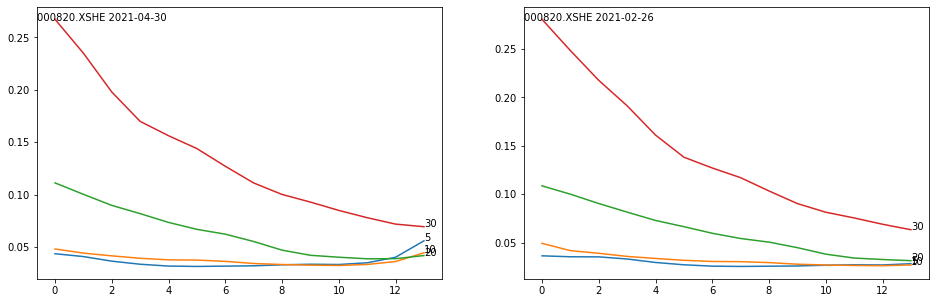

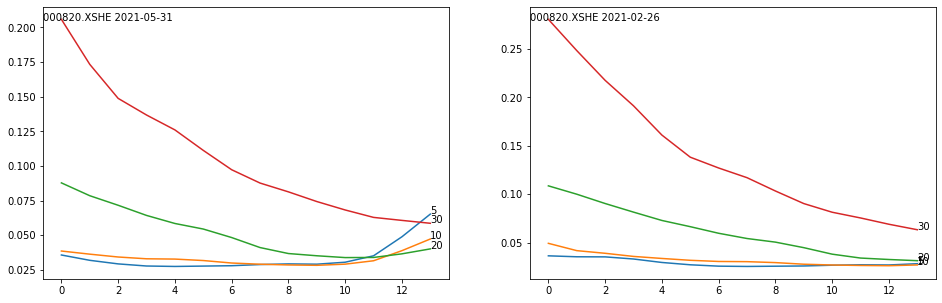

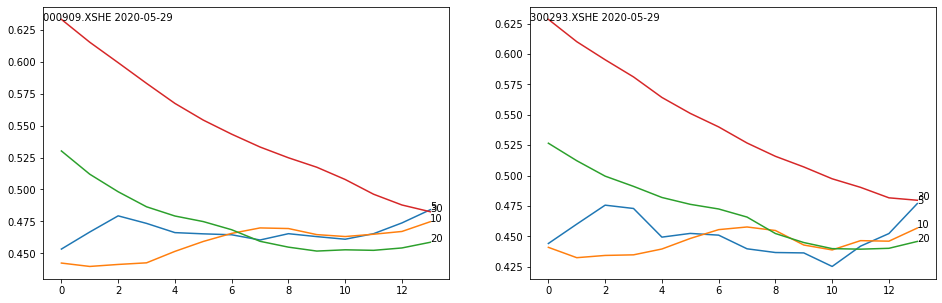

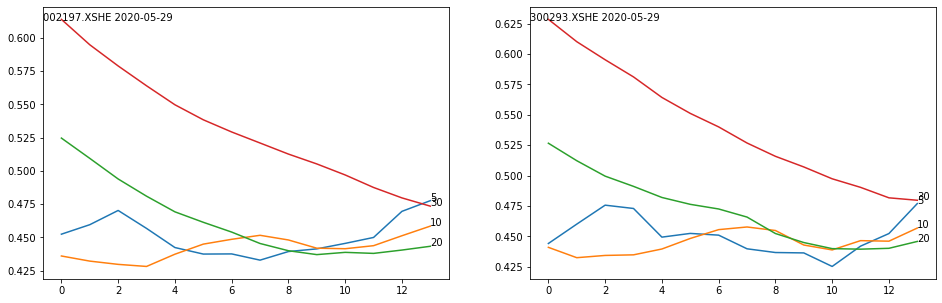

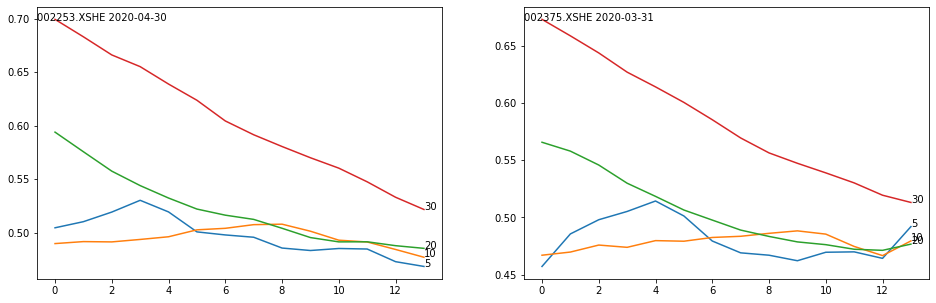

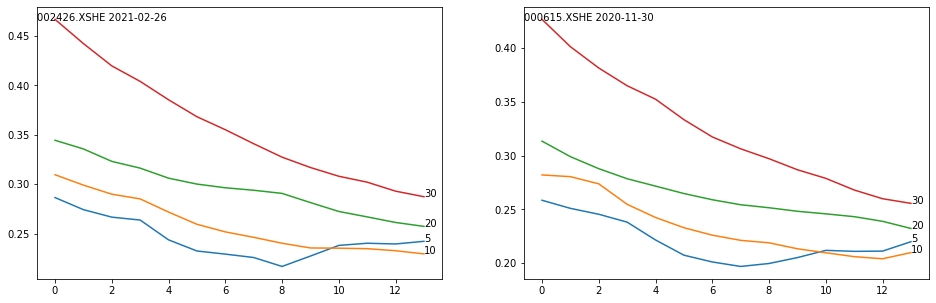

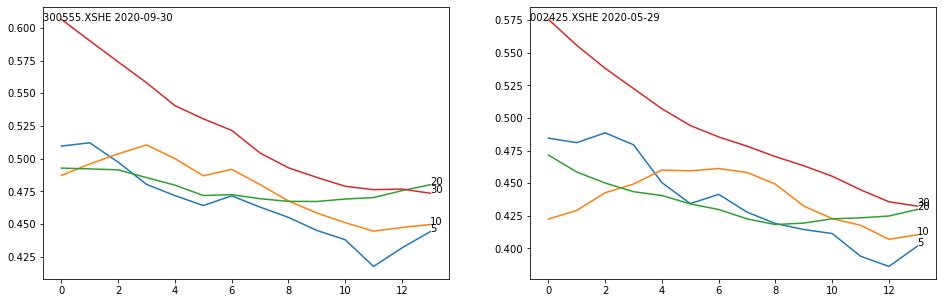

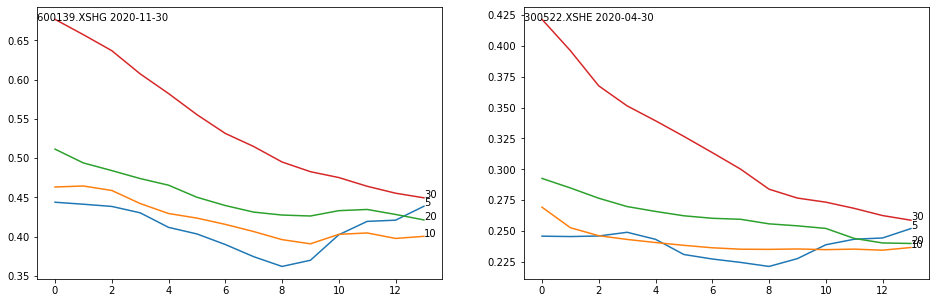

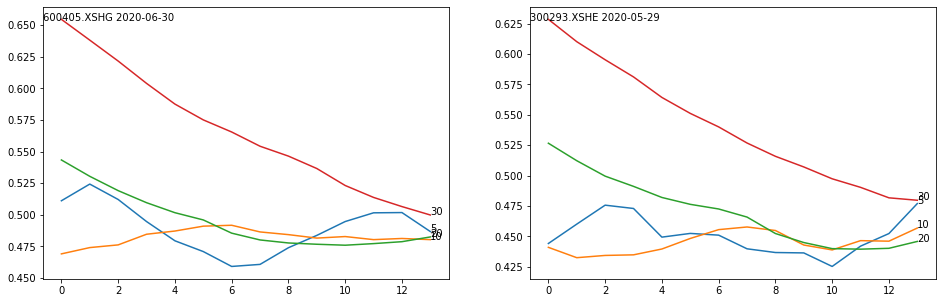

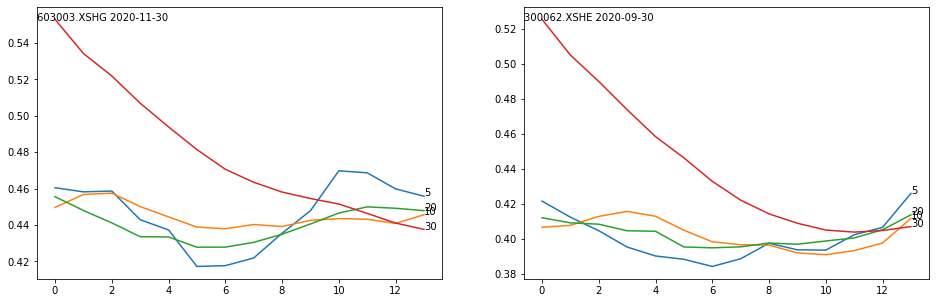

In [505]:
for row in sim_vecs[(sim_vecs.dis > 1e-3) & (sim_vecs.dis<0.07)].to_records():
    _, name1, frame1, name2, frame2, _ = row
    parallel_show(name1, frame1, name2, frame2)

# 月线涨幅大于35%,首月大涨的

In [524]:
for code in choose_stocks():
    bars = get_bars(code, 2, end=None, unit="1M")
    if len(bars) != 2 or bars["date"][1] != datetime.date(2021, 9, 30):
        continue
        
    close = bars["close"]
    adv = close[1]/close[0] - 1
    if 0.25 < adv < 0.4:
        print(get_name(code), code)

粤电力A 000539.XSHE
建投能源 000600.XSHE
新希望 000876.XSHE
湖北能源 000883.XSHE
东方能源 000958.XSHE
蓝焰控股 000968.XSHE
招商积余 001914.XSHE
招商蛇口 001979.XSHE
天润工业 002283.XSHE
杰瑞股份 002353.XSHE
天顺风能 002531.XSHE
洽洽食品 002557.XSHE
凯莱英 002821.XSHE
中国广核 003816.XSHE
奥克股份 300082.XSHE
泰格医药 300347.XSHE
富祥药业 300497.XSHE
贝达药业 300558.XSHE
诚迈科技 300598.XSHE
开立医疗 300633.XSHE
朗新科技 300682.XSHE
壹网壹创 300792.XSHE
中远海能 600026.XSHG
浙江新能 600032.XSHG
广州发展 600098.XSHG
广汇能源 600256.XSHG
安琪酵母 600298.XSHG
平高电气 600312.XSHG
福能股份 600483.XSHG
深高速 600548.XSHG
京能电力 600578.XSHG
氯碱化工 600618.XSHG
川投能源 600674.XSHG
上海石化 600688.XSHG
阳煤化工 600691.XSHG
通策医疗 600763.XSHG
新潮能源 600777.XSHG
国电电力 600795.XSHG
国投电力 600886.XSHG
绿色动力 601330.XSHG
嘉泽新能 601619.XSHG
平煤股份 601666.XSHG
中国电建 601669.XSHG
招商轮船 601872.XSHG
中国核电 601985.XSHG
大唐发电 601991.XSHG
台华新材 603055.XSHG
和邦生物 603077.XSHG
新亚强 603155.XSHG
九洲药业 603456.XSHG
司太立 603520.XSHG
健友股份 603707.XSHG


In [526]:
240 * 250 * 5000/(1000*1000*1000)

0.3

# 月线三连阳

底部启动，月线三连阳

In [12]:
def backtest():
    data = load_monthly_bars()

    X, y = [], []
    for code, bars in data.items():
        for i in range(4, len(bars) - 1):
            xbars = bars[i-4:i]
            ybars = bars[i]
            
            xclose = xbars["close"]
            xvolume = xbars["volume"]
            
            pcrs = xclose[1:] / xclose[:-1] - 1
            pvrs = xvolume[1:] / xvolume[:-1]
            
            name = jq_get_name(code)
            
            y_ = ybars["close"] / xclose[-1] - 1
            
            X.append([*pcrs, *pvrs])
            y.append(y_)

    return X, y

X, y = backtest()

In [20]:
import xgboost
from xgboost import XGBRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform


def grid_search(X_train, y_train):
    params = {
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 0.5),
        "learning_rate": uniform(0.03, 1),
        "max_depth": randint(2, 6),
        "n_estimators": randint(100, 150),
        "subsample": uniform(0.6, 0.4),
    }
    model = XGBRegressor()
    search = RandomizedSearchCV(
        model,
        param_distributions=params,
        random_state=42,
        n_iter=10,
        cv=3,
        verbose=2,
        n_jobs=8,
        return_train_score=True,
    )


    search.fit(X_train, y_train)

    _report_best_scores(search.cv_results_)
    return search.best_estimator_

def _report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
model = grid_search(np.array(X_train), np.array(y_train))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.7619939418114051, max_depth=2, n_estimators=120, subsample=0.6624074561769746; total time=   8.2s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.7619939418114051, max_depth=2, n_estimators=120, subsample=0.6624074561769746; total time=   8.3s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.7619939418114051, max_depth=2, n_estimators=120, subsample=0.6624074561769746; total time=   8.3s
[CV] END colsample_bytree=0.7061753482887407, gamma=0.48495492608099716, learning_rate=0.8624426408004218, max_depth=3, n_estimators=101, subsample=0.6727299868828402; total time=   9.9s
[CV] END colsample_bytree=0.7061753482887407, gamma=0.48495492608099716, learning_rate=0.8624426408004218, max_depth=3, n_estimators=101, subsample=0.6727299868828402; total time=  10.2s
[CV] EN

In [26]:
preds = model.predict(np.array(X_test))

array([ 0.01324193, -0.09665151,  0.04815235, ..., -0.03482336,
       -0.04790377, -0.02377158])

In [27]:
for ypred, ytrue, gap in zip(preds, y_test, preds - np.array(y_test)):
    print(ypred, ytrue, gap)

0.030898433 0.017656500802568198 0.013241932376095056
0.0032107478 0.09986225895316814 -0.09665151110583459
-0.008854774 -0.05700712589073631 0.048152352063839166
-0.019852584 -0.10762331838565031 0.08777073415773073
0.019060345 -0.014175257731958713 0.03323560309855589
-0.008377101 -0.03312302839116721 0.02474592711882262
-0.008477831 -0.03830645161290336 0.029828620353533508
-0.013916438 0.002008032128514081 -0.015924470573962957
0.040401228 0.23254620123203296 -0.19214497345979709
0.010472493 -0.03245283018867917 0.04292532343487687
0.006534452 0.00978792822185981 -0.0032534761374078958
-0.0074052247 0.006928406466512715 -0.014333631188391482
0.017506557 -0.05752212389380529 0.07502868047923639
0.014257465 0.02617801047120416 -0.011920545913318037
0.0067336387 -0.09911242603550297 0.10584606473560076
0.009147879 0.0277777777777779 -0.018629899041520348
0.02991166 -0.026156941649899346 0.056068601307854515
-0.054628126 -0.08842105263157896 0.03379292630835584
-0.012711222 -0.02462620

-0.0029444878 0.0015151515151516914 -0.004459639360676837
0.0116054 0.0740418118466899 -0.06243641218592377
0.020254722 0.05664488017429181 -0.036390158309233867
-0.008289607 -0.03298969072164937 0.024700083479899604
0.011601732 0.041699449252557086 -0.030097717140089797
0.009865187 -0.06820765441455101 0.0780728415230677
-0.017884726 -0.47950089126559714 0.461616165560808
-0.049020145 0.010849909584086825 -0.059870054672521045
-0.02733326 -0.22518518518518515 0.19785192560266562
-0.006769707 -0.022413793103448265 0.015644086142680758
0.003343148 0.08630952380952372 -0.08296637588535383
0.0044064946 0.08053134080531343 -0.07612484625118121
0.02532501 -0.046843177189409446 0.07216818678873749
-0.013667875 0.010516252390057268 -0.024184127359599294
8.306201e-06 0.06915629322268324 -0.0691479870213032
-0.006195242 -0.07581573896353155 0.06962049691249639
0.011289849 -0.05118411000763945 0.06247395895367436
0.031261742 0.26315789473684204 -0.23189615262182128
0.016645975 -0.071428571428571

0.028105106 0.0038804811796664396 0.024224625025081714
-0.04129157 -0.01005025125628145 -0.03124131717199652
0.0030389389 0.12751091703056772 -0.12447197817481537
0.0036653138 -0.04144144144144135 0.04510675526458996
0.010355362 0.03454545454545466 -0.02419009280814377
-0.017292852 0.12676056338028174 -0.14405341496245128
-0.035862572 0.08509316770186315 -0.12095574019303212
-0.09145287 -0.014293276866066629 -0.0771595899266122
0.056690823 0.4185185185185185 -0.36182769523174674
-0.0013719348 -0.06693440428380193 0.06556246950667621
0.002203881 0.015296367112810794 -0.013092486070732656
-0.011954611 -0.007792207792207906 -0.004162403375103763
-0.009096608 -0.17791411042944794 0.16881750286356811
-0.012621208 0.15815085158150843 -0.17077205967556885
0.043762516 0.4462527627084589 -0.40249024647811416
0.006075436 0.1420313790255987 -0.13595594324188465
0.025944494 -0.007768666378938471 0.03371316008993319
-0.028252224 0.07913669064748219 -0.10738891415405205
0.021923942 0.035591274397244

-0.02001447 -0.0515759312320917 0.03156146078896216
0.001334728 -0.058413719185423374 0.059748447160031914
-0.006086813 -0.07968843618933508 0.07360162336904952
-0.038206115 0.020648967551622377 -0.05885508291665076
-0.006091898 0.06134969325153383 -0.06744159109307679
0.05204651 0.08501594048884176 -0.032969429166581854
0.0003812877 -0.0735068912710567 0.07388817898226352
0.015552828 0.18918918918918926 -0.1736363611007865
-0.004404118 0.019246190858059453 -0.023650308676981258
-0.008615414 0.025365853658536608 -0.03398126733920925
-0.04196789 -0.1289424860853431 0.08697459492866966
0.017609788 0.13717128642501764 -0.11956149832012586
-0.0014289255 0.0011587485515642815 -0.002587674100244408
0.031797756 -0.06875543951261975 0.1005531950222347
0.021264033 0.028831562974203306 -0.0075675295821315824
-0.007919982 0.10084033613445387 -0.10876031821014509
0.010057102 -0.04966887417218535 0.05972597612968533
0.0055746515 -0.03498542274052485 0.040560074268674695
-0.007053234 0.0328031809145

0.012616999 0.011575562700964603 0.0010414367463811303
4.1225645e-05 -0.03734439834024905 0.03738562398521261
0.039220385 0.02784810126582271 0.011372283987606702
-0.0024138156 0.01051939513477973 -0.012933210720676103
-0.0017115013 0.26765799256505574 -0.26936949383931363
0.014612641 -0.0013440860215054862 0.015956727207027566
0.022618588 0.011267605633802802 0.011350982426337808
0.015411802 -0.25727069351230425 0.2726824951485233
-0.0016054087 0.0114135206321333 -0.013018929363981302
0.021297961 0.16400000000000015 -0.14270203852653518
-0.0032101555 -0.14424778761061952 0.14103763208444342
0.0072378586 -0.054601497137824806 0.061839355742464575
-0.017015472 0.045494313210848514 -0.06250978526533002
0.014854128 0.012019230769230616 0.00283489677195381
0.014994795 -0.03677758318739055 0.05177237862156747
0.020169688 -0.1188118811881188 0.13898156957682406
-0.010048021 -0.06593406593406603 0.05588604530299113
0.0051961956 -0.025940811107051598 0.031137006668490397
-0.0034187809 0.019434

0.038685735 -0.2804718217562254 0.3191575570713099
0.068123095 -0.09023354564755837 0.15835664038508812
0.04995612 0.21989158614188065 -0.16993546559124817
0.011762627 0.04210526315789487 -0.03034263575743701
-0.00073532184 0.007367716008037428 -0.008103037846911798
-0.036394287 -0.18140996856757963 0.14501568166682088
-0.04138866 -0.0189473684210526 -0.02244129224827418
0.016968109 -0.03668763102725359 0.05365573974088045
-0.0053666574 -0.0330935251798562 0.02772686778494038
0.117226765 0.13103953147877 -0.013812766919024222
0.0041143023 0.013782542113323082 -0.009668239772428144
-0.02632414 -0.02208201892744477 -0.004242120980511355
0.013213385 0.15856236786469347 -0.14534898296817667
0.014102785 0.09851088201603653 -0.08440809709927799
0.008199045 -0.016225448334756698 0.024424493769350852
-0.0088012805 -0.09629629629629621 0.08749501577543983
0.0040739565 -0.011450381679389388 0.015524338195029408
0.015218624 0.09615384615384626 -0.0809352222400217
-0.0034290578 -0.1637776449491931

-0.0047738226 -0.002051282051282022 -0.0027225405617784526
-0.006733778 0.007481296758104827 -0.014215074690927532
-0.001416323 -0.03993203058623607 0.038515707578220315
0.059847463 0.18382352941176472 -0.12397606648943005
0.0048158844 0.04712041884816753 -0.04230453444800841
-0.0113466345 0.18922470433639949 -0.20057133881377642
0.006373524 -0.057010785824345156 0.06338431002451639
-0.005745207 -0.030577869914485745 0.024832662954940132
0.024066335 0.03693181818181812 -0.012865483591502302
-0.0046658427 -0.04632587859424919 0.04166003584879607
-0.0032065818 -0.005015045135406293 0.0018084633267796413
-0.023400733 -0.18037383177570088 0.15697309852830155
0.0067897276 -0.1702544031311154 0.1770441307332694
-0.008645795 0.0015552099533437946 -0.010201005239045546
0.0023696255 -0.03545051698670598 0.03782014248059007
-0.012247938 -0.010183299389001976 -0.0020646383424428594
-0.010613245 0.07293497363796142 -0.08354821859618333
-0.066310816 -0.19884169884169878 0.13253088332856477
0.026582

0.0007511855 0.3311546840958606 -0.3304034985739115
-0.0063140127 0.13217623497997333 -0.13849024766762663
0.00075880677 -0.01851851851851849 0.019277325285926294
-0.0010507085 -0.012269938650306678 0.011219230184097206
0.017256847 0.003875968992248069 0.01338087765918683
-0.011688741 -0.0045977011494251485 -0.0070910397745755915
0.013852972 -0.009980039920159611 0.023833011526116166
-0.0015306894 0.0765306122448981 -0.07806130166507663
0.004814735 0.07262236370871467 -0.06780762856061262
0.0040114583 0.041297935103244754 -0.037286476851619454
0.008734115 -0.012254901960784381 0.020989017360204643
-0.029613545 0.08288482238966655 -0.11249836755413245
0.0622566 0.024977698483496846 0.03727890222427255
-0.00018793283 -0.15205479452054782 0.15186686168675145
-0.02497417 0.11699959233591506 -0.14197376154551455
0.015662614 -0.08265837431298817 0.09832098856913174
-0.007217757 -0.05520544492059498 0.04798768798240571
-0.040249713 0.04991568296795945 -0.09016539573317628
0.016738497 0.013104

0.020172259 0.06821963394342756 -0.04804737510441637
0.02242211 -0.10818307905686553 0.1306051897187298
0.0077277157 0.01355578727841511 -0.005828071625979092
0.05067379 0.06046676096181036 -0.009792970685759794
-0.014943832 0.10143702451394754 -0.11638085611419635
-0.11096544 -0.2614840989399294 0.15051866075280707
0.0029329231 -0.06745562130177507 0.07038854444922993
-0.022670273 0.03562945368171033 -0.0582997264194518
0.017363293 -0.04235294117647048 0.05971623427289363
0.009888338 -0.0337349397590363 0.04362327768411278
0.0052021113 -0.14105263157894732 0.14625474290138007
-0.0071405247 -0.032432432432432434 0.02529190774704959
0.02576761 -0.09703504043126676 0.12280264990830991
0.004622442 -0.037771482530689404 0.04239392471284287
0.0049006855 0.1968503937007875 -0.19194970818925805
0.013968496 0.009287925696594312 0.00468056995548527
-0.011521767 0.31971580817051515 -0.3312375750640808
0.01547851 -0.024937655860349017 0.0404161662699426
-0.010674018 -0.0012180267965896663 -0.0094

-0.009869688 0.0031612223393044925 -0.013030910529824302
0.0047663897 -0.047671840354767125 0.052438230082359594
0.019466924 -0.006160164271047264 0.025627087820818573
-0.004129085 0.08262910798122047 -0.08675819320534228
0.013056237 0.02451225612806418 -0.011456018877497698
-0.032614477 0.06813186813186833 -0.10074634511064717
0.015737537 -0.022727272727272707 0.03846481002189894
0.017064413 -0.09486931268151022 0.11193372573728777
0.028972166 -0.19536757301107754 0.22433973867014756
-0.0014465668 -0.07946752722872119 0.07802096045141738
-0.022232385 0.14427860696517425 -0.16651099231742816
-0.011221886 -0.002666666666666595 -0.008555219014485749
-0.0017703491 -0.06888168557536467 0.06711133647233858
0.028925104 -0.04100946372239744 0.06993456778912699
0.027289106 0.22204472843450485 -0.19475562285524783
-0.0014568979 0.3168886198547216 -0.31834551779334563
0.0032467071 0.1769505354411014 -0.17370382829783937
-0.009348711 -0.017173051519154492 0.007824340520261708
-0.039399043 -0.0383

-0.0032626542 -0.038245219347581516 0.03498256516787435
0.007437589 -0.12227805695142369 0.12971564606409292
-0.0082295975 -0.05147058823529416 0.04324099076363974
-0.004951813 0.03840472673559825 -0.04335653952816765
-0.0042787753 0.011494252873563315 -0.01577302817811921
-0.011089414 0.18816067653276947 -0.1992500908909085
-0.0042772344 0.1738002594033723 -0.17807749383472848
0.018054483 0.19109461966604835 -0.17304013620764858
0.015518149 -0.13031218529707955 0.14583033465809392
0.0045970418 -0.10876132930513593 0.11335837106105062
0.007295045 0.026006711409396033 -0.018711666339045863
-0.02533087 -0.12335216572504693 0.0980212962440794
-0.013659167 -0.06323185011709598 0.049572683013626606
0.017162418 0.17788461538461542 -0.16072219739166593
-0.029592475 -0.04219409282700437 0.012601617904466567
0.018789383 0.11004126547455306 -0.09125188282310481
-0.010645945 -0.019439679817038313 0.008793735191899077
-0.0205747 -0.02517162471395884 0.004596924626649956
0.01025047 0.12334152334152

0.007791221 -0.056291390728476776 0.06408261187029196
0.020626592 -0.02254986990459673 0.04317646142311804
0.0023761466 -0.027128157156220634 0.029504303770772178
-0.01883722 -0.10161662817551964 0.08277940907134884
-0.0009935106 -0.015605749486653053 0.014612238894855523
-0.02179914 -0.05637982195845703 0.03458068227997879
-0.0033254642 0.025542784163473664 -0.028868248367427407
0.048874322 0.18968133535660092 -0.1408070130316097
0.013168654 -0.03574468085106386 0.04891333525564445
-0.014752483 -0.06861063464837058 0.05385815165297969
0.045457553 0.06439393939393945 -0.018936386275472117
0.014411421 0.07386363636363624 -0.05945221580226301
-0.018403295 -0.02714932126696834 0.008746025839407534
-0.006028947 0.035310734463276816 -0.04133968141803379
-0.0020871495 0.022222222222222143 -0.024309371758459264
0.04733698 0.0 0.04733698070049286
-0.003274361 -0.05847953216374269 0.0552051712592726
0.0105963275 0.052851182197496405 -0.04225485471384238
-0.0028588825 0.14690265486725673 -0.1497

-0.008327183 0.121939736346516 -0.13026691966018378
0.0054983995 -0.07963446475195823 0.08513286424431143
-0.05981619 0.011369253583786376 -0.07118544269406546
0.0050569684 -0.06844741235392326 0.0735043807783925
-0.0010022664 -0.03192848020434225 0.03092621378335947
-0.0073106065 0.039017341040462394 -0.046327947579711815
0.0063423407 -0.01151515151515159 0.01785749224155697
0.00596174 -0.07699999999999996 0.08296173992380496
0.014566186 -0.04761904761904756 0.062185233503225246
0.0037673728 -0.11212121212121207 0.11588858492869991
0.017880863 0.04571428571428582 -0.02783342313553616
0.0052198865 -0.07079318013343217 0.07601306667852403
-0.0022549422 -0.0493827160493826 0.04712777385016731
0.014236535 -0.03536345776031424 0.04959999270598103
-0.006132158 -0.028066528066527985 0.021934370081406973
-0.012349922 -0.06551059730250497 0.053160675092526866
-0.0002435599 -0.06756756756756754 0.06732400766584856
-0.009247586 0.07769423558897226 -0.08694182172006815
-0.046697002 0.138014527845

0.026776077 -0.1606498194945848 0.18742589672038912
0.0049608015 -0.0953237410071941 0.1002845424595924
0.003837567 -0.01698513800424628 0.020822705059844182
-0.013454711 -0.08249068653539116 0.06903597547069484
-0.0059113954 0.03347280334728042 -0.03938419876666943
0.019337432 0.14025623735670933 -0.12091880489771256
0.009320255 -0.06545247581104141 0.0747727311799894
0.007576491 -0.20238843494657455 0.2099649261646348
-0.020017244 -0.041173152848279826 0.02115590892652308
0.010744111 -0.010438413361169019 0.0211825240422856
0.02087041 -0.08432432432432424 0.10519473423023473
-0.000872281 -0.09480269489894144 0.09393041392639734
-0.0017020165 -0.09171459661122339 0.09001258015889602
-0.001527359 0.12940057088487156 -0.13092792989552327
0.00487854 -0.07925072046109516 0.08412926051878411
-0.079248406 0.051362215274676215 -0.130610621267661
0.0062230066 0.10429447852760743 -0.09807147188797782
-5.615802e-05 -0.16000000000000003 0.15994384197998446
-0.022587167 0.0093131548311991 -0.0319

-0.0009774675 -0.1333333333333333 0.13235586582062142
0.024314294 0.3234714003944772 -0.29915710675660545
0.024512684 -0.09660574412532641 0.12111842809804274
0.02783458 0.004357298474945592 0.023477280873618556
0.027212363 -0.06494960806271 0.09216197079917354
-0.010764584 -0.25968797181680925 0.2489233878715349
-0.033412233 -0.10263060392738055 0.06921837093234728
0.019866489 -0.06172839506172856 0.08159488393568715
-0.0053811097 -0.0714285714285714 0.0660474617699427
-0.0016457919 -0.01058201058201047 0.008936218655589245
0.016885914 -0.10233393177737882 0.11921984568586041
0.0031019154 -0.022792022792022637 0.025893938145931772
0.00277031 0.03477218225419665 -0.03200187221922124
0.013844452 0.04382470119521931 -0.029980249328175335
0.03021382 0.3068237604320079 -0.2766099406152993
0.0054337005 -0.013752455795677854 0.019186156308772517
0.008530682 0.058568329718004186 -0.05003764776517006
-0.01812556 -0.03347280334728031 0.015347243212631034
0.006043699 0.0017152658662091813 0.0043

0.011938806 0.24116798846431142 -0.22922918277241355
-0.002845075 -0.1681901279707495 0.16534505298929847
0.045448042 0.040494938132733305 0.004953104319602053
0.0071277465 -0.12831858407079644 0.13544633054479427
0.009215323 0.0253353204172877 -0.016119997162821642
0.05227963 0.048101265822784844 0.00417836299048191
0.010125062 0.1469072164948455 -0.13678215406643068
0.01323309 -0.10547945205479448 0.11871254187434499
0.024014078 0.09929078014184411 -0.07527670206118997
0.011947575 0.22300469483568075 -0.2110571198104203
0.0027463564 -0.007168458781361964 0.009914815199718263
0.015171325 0.06985645933014362 -0.054685134495916055
0.16662456 0.09883321894303365 0.06779134200915293
-0.0022106688 -0.04909090909090896 0.046880240337076384
-0.010034165 -0.027141133896260494 0.017106968551128143
-0.0013871572 -0.014981273408239737 0.01359411616363193
0.021332363 0.04525862068965525 -0.023926258022929137
0.008307219 0.014606741573033544 -0.0062995230213978015
0.028870627 -0.09295774647887312 

0.0137034245 -0.034329563812600994 0.04803298829613867
0.010435744 0.13913913913913922 -0.12870339495041327
-0.028952764 -0.08620689655172409 0.05725413220452846
-0.018634418 0.014128728414442682 -0.03276314644005551
0.023880564 0.25373134328358216 -0.2298507796072249
0.0027197774 -0.008205128205128198 0.010924905608527546
-0.010870836 0.09433962264150941 -0.10521045838535392
-0.021538608 -0.04815864022662886 0.02662003245046385
0.012250491 -0.02652519893899208 0.03877569035693651
-0.1151899 -0.035964035964035856 -0.0792258665203811
0.022528242 -0.0052631578947368585 0.02779140021455917
-0.014396563 0.0783722682743031 -0.0927688314466435
-0.011260992 0.011316872427983515 -0.022577864344043963
0.013912349 0.21004566210045672 -0.19613331309243298
-0.021021398 -0.06366047745358094 0.04263907966922864
-0.009001494 -0.160202360876897 0.15120086649159492
0.020991692 0.030612244897959107 -0.00962055257844674
-0.027314715 -0.14285714285714302 0.11554242776972923
-0.017798996 -0.169215086646279

0.0008716581 0.01789077212806034 -0.01701911403569567
-0.0117602805 -0.13666666666666671 0.12490638619909689
0.01968102 0.030751034890597273 -0.01107001518208306
0.015885219 -0.025210084033613356 0.04109530301154152
0.011524477 -0.20024271844660202 0.2117671954888598
-0.0032410757 0.03733031674208154 -0.04057139241056551
-0.0073101795 0.08990536277602534 -0.0972155423038743
0.0060908017 -0.06373975138852161 0.06983055306339425
0.017958399 0.07229832572298323 -0.05433992681460653
-0.008770789 -0.12145110410094628 0.11268031508118281
0.027512703 0.183300395256917 -0.15578769216601085
-0.006312137 -0.069672131147541 0.06335999414355298
-0.008015344 -0.17274472168905952 0.16472937776966312
0.027247487 -0.014627659574467988 0.04187514621051058
0.048937075 0.11418376449598555 -0.06524668965591673
0.020721873 -0.2621951219512194 0.2829169952197045
0.010570231 0.11610486891385774 -0.10553463802006702
-0.013134541 -0.027237354085603127 0.014102813095608124
0.0020493814 0.13329551900170178 -0.13

0.022574183 0.009965122072745247 0.012609060527037697
0.020626282 0.03819444444444464 -0.017568162125018105
0.03166851 0.368421052631579 -0.3367525423435789
0.0048273797 0.24633431085043989 -0.2415069311357423
-0.023355119 -0.13128491620111737 0.10792979727077756
-0.07868109 -0.13968253968253963 0.06100145069852703
-0.002744208 0.006015037593984918 -0.008759245683992223
0.0033755058 -0.009783115068067616 0.013158620863769954
0.02442558 0.09042553191489366 -0.06599995267993597
0.008622183 -0.03205128205128205 0.040673465515749574
-0.009036005 -0.019768234492160808 0.010732229948856364
0.0056165303 -0.04869358669833734 0.05431011700869992
0.011523445 -0.023086269744836074 0.034609714881681186
-0.003709502 0.040257648953301084 -0.04396715100581683
0.0103720315 0.08116883116883122 -0.0707967996887573
0.009008896 0.12802768166089962 -0.11901878605509708
0.092960924 -0.0351526364477337 0.1281135603578747
-0.00094794837 0.057613168724279795 -0.058561117094874326
0.004927644 0.0475659606094389

0.01007993 -0.005643340857787726 0.015723270462914107
-0.0062477156 0.011641443538998875 -0.0178891590978556
-0.003473053 0.05476673427991896 -0.05823978726774781
-0.0036292865 -0.027472527472527486 0.023843240931855303
0.027750434 0.06870229007633588 -0.04095185572238824
0.008006806 0.11764705882352944 -0.10964025326949711
0.016516633 -0.011463844797177991 0.027980478128953656
-0.0007781874 0.05201499531396436 -0.05279318272952693
0.010246434 0.03606965174129373 -0.02582321749230987
0.012291555 -0.040644171779141036 0.05293572707204541
0.005327053 0.0374707259953162 -0.032143673092885905
-0.056338914 0.3970338983050845 -0.4533728120438121
0.003116431 0.04530201342281881 -0.04218558247526172
-0.00042022968 -0.18464528668610292 0.1842250570020071
0.0332782 0.04645760743321725 -0.013179406657832349
-4.8322136e-06 -0.05996131528046411 0.05995648306690149
-0.013932904 0.03698630136986303 -0.050919205598431105
-0.012940407 0.14887436456063918 -0.1618147713599556
0.00421399 -0.26536731634182

-0.0015710944 0.059270516717325084 -0.06084161110174202
-0.0013462564 0.051114023591087854 -0.05246027994218627
-0.0004808727 -0.015243902439024293 0.014763029743690037
-0.016969547 -0.09461966604823746 0.07765011937255539
0.025234425 0.09916367980884111 -0.07392925436841047
0.001481337 -0.05128205128205132 0.052763388289186475
0.043306198 0.09572901325478655 -0.05242281528368098
0.057529993 -0.047681254082299174 0.10521124743757337
0.011234957 -0.08673469387755106 0.09796965067103813
0.058712047 0.013157894736842035 0.04555415185658562
0.000923809 0.015143017386427537 -0.014219208373098091
0.024492232 0.25313945803040316 -0.2286472259014254
0.021858603 0.04272517321016167 -0.02086657044793938
0.023716554 0.010067114093959662 0.013649439951717524
0.025038278 -0.0907967881408277 0.11583506587117343
0.0098438915 -0.5088902513795217 0.5187341428660472
0.00414199 0.1083591331269349 -0.10421714303155794
-0.0071374923 -0.11533052039381153 0.10819302809473164
-0.003719319 -0.03827281648675162

0.01819027 -0.08039492242595214 0.09858519271573085
0.010957483 -0.024805102763997167 0.035762585966216176
0.0068096095 -0.004750593824228044 0.011560203300704952
0.011859083 -0.02897959183673471 0.04083867445360034
0.030938474 0.02682403433476388 0.004114440126672392
-0.024845995 -0.006726457399103158 -0.018119537609842307
0.016259955 0.14263322884012553 -0.12637327359784933
-0.0050124307 0.008975317875841604 -0.013987748592147575
-0.012166847 -0.0167504187604689 0.004583572216918408
-0.029028933 0.15062761506276168 -0.1796565485580448
0.019281 -0.07854406130268199 0.09782506120159251
0.012499581 0.00493421052631593 0.007565370564790008
0.02536539 0.07758620689655182 -0.052220817013033605
0.02756332 -0.039787798408488007 0.0673511188813245
-0.045694795 -0.06956521739130417 0.02387042288546959
0.011250099 -0.10575016523463332 0.11700026440186106
-0.024216153 -0.027624309392265123 0.0034081566646612105
0.009408219 0.04198966408268734 -0.032581445296566924
0.019948827 0.04961832061068705

0.011974205 -0.12352941176470589 0.1355036170276649
-0.0029364831 0.05282112845138043 -0.055757611579376753
0.012007628 -0.0301659125188537 0.04217354015504793
0.021838361 0.33576642335766427 -0.31392806196027867
0.0047193016 0.0379834254143645 -0.03326412382180588
-0.00904145 0.08745874587458746 -0.09650019586098568
-0.050321147 -0.06740400667779645 0.01708285983197888
0.028271506 0.0814159292035399 -0.053144423594385204
-0.019429402 -0.0934959349593496 0.0740665325334644
0.0008682773 -0.12486368593238817 0.12573196320739166
-0.008793031 -0.08064516129032262 0.07185213042483218
-0.012202836 0.04744958481613293 -0.059652420457934285
0.007626085 -0.08678955453148995 0.09441563960797106
0.021906566 -0.21759500260281106 0.23950156847762605
0.0022858283 -0.14748953974895396 0.14977536809720315
0.013048703 -0.05110732538330487 0.06415602823424271
-0.014520779 0.1095890410958904 -0.12410982034794271
-0.012072441 0.7291487532244194 -0.7412211943925489
-0.0018083173 0.07624113475177308 -0.0780

0.012932657 0.2536764705882353 -0.24074381332406225
-0.0025330863 -0.08464125560538127 0.08210816926264419
0.0073082573 0.01877708233028419 -0.011468825052229237
-0.036752786 -0.09507042253521125 0.058317636047870325
-0.0032993588 -0.03678357570573132 0.033484216939205336
-0.014412917 -0.037987679671458 0.023574762474707356
-0.013180127 0.08012126461671731 -0.0933013919840946
-0.015866151 0.03149001536098317 -0.047356166440518654
0.0074942294 -0.2244039270687237 0.23189815642641332
0.029681964 0.04415584415584406 -0.014473880309756604
-0.011937422 -0.1630434782608695 0.15110605651431752
-0.023505017 -0.012063492063491998 -0.011441525097877325
-0.008088877 0.029761904761904878 -0.03785078218650262
-0.030875754 -0.06641895030190426 0.03554319669057804
-0.009520278 -0.09347826086956512 0.08395798255729925
-0.0067625656 -0.4264892268694549 0.41972666129018954
0.019610614 0.05688622754491024 -0.03727561396039181
0.013830076 0.06373517786561278 -0.04990510189383057
-0.013383085 -0.0239774330

-0.008184136 -0.009900990099009799 0.0017168542075126636
-0.006372096 -0.09737248840803703 0.09100039239103397
0.012447864 -0.02857142857142858 0.04101929238864355
0.006390874 0.014619883040935644 -0.0082290092325219
-0.019397976 -0.05466666666666664 0.035268690789739265
0.013124289 -0.07386363636363635 0.08698792535472999
0.015171993 -0.3597328244274809 0.37490481701999445
-0.017806092 0.009852216748768461 -0.02765830902593769
-0.0067374813 0.059445178335534976 -0.06618265967257564
0.00169962 -0.13095238095238093 0.1326520009953085
0.006328706 0.0185185185185186 -0.01218981235460559
0.00014225063 0.06275468622656888 -0.06261243559451657
-0.0038086069 0.06662804171494785 -0.07043664859659615
-0.00367485 -0.03688524590163933 0.033210395800987946
0.010203207 0.08836206896551735 -0.07815886205383427
-0.0028998307 -0.16531165311653118 0.1624118224212895
0.0014699737 0.017738359201773912 -0.016268385494202287
0.0019415942 -0.05660377358490576 0.05854536776369412
-0.0017065009 -0.12008978675

0.0099091455 0.17277486910994755 -0.162865723575909
0.0021999746 -0.020547945205479423 0.022747919815018336
-0.005340221 -0.12310437109723471 0.11776415022492193
0.0031315675 -0.01949860724233976 0.022630174742871434
0.032415144 0.27986906710310966 -0.24745392295762092
0.0075366334 0.056213017751479244 -0.04867638434564481
0.05802979 -0.24145006839945282 0.29947985787703957
-0.014571138 0.18421052631578938 -0.1987816640420963
-0.019913638 0.3333333333333335 -0.35324697134395455
0.02291744 0.043014845831747195 -0.020097405670638224
0.013062704 -0.120669056152927 0.1337317605074516
-0.10613784 -0.10803757828810023 0.0018997363481740859
0.017310085 -0.006993006993006978 0.024303091768097196
0.021715477 0.011869436201780381 0.009846040907175002
0.014992777 -0.026059654631083284 0.041052431889241014
0.018665556 0.07122905027932958 -0.05256349441475705
0.006190852 -0.03218390804597693 0.038374759842395356
0.007644909 -0.1595197255574613 0.16716463452582053
-0.0138355475 0.01179941002949847 -

0.008258402 -0.12330316742081449 0.13156156976837918
0.001779816 -0.12204424103737599 0.12382405703437305
0.008081459 -0.06929248723559456 0.07737394667588549
0.005027966 0.03178340200117735 -0.02675543589300422
0.031762462 0.01230477993374346 0.019457682175583857
0.010608555 -0.0685714285714285 0.07917998338916465
0.014637782 -0.036002939015429836 0.05064072125385366
-0.014119655 0.4231974921630095 -0.4373171470568846
0.0075550284 0.09070034443168762 -0.08314531600802066
-0.0030291805 -0.03341288782816243 0.030383707370346902
-0.0082396725 -0.19939577039274925 0.19115609787348264
0.00034726463 -0.036832412523020164 0.037179677157931135
0.001079598 0.017021276595744705 -0.015941678619685984
-0.0067080925 0.0 -0.006708092521876097
0.008053388 -0.08839285714285716 0.0964462455894266
-0.0074898223 -0.07218992248062028 0.06470010014135374
0.054605093 0.020805369127516737 0.03379972372579099
-0.0033191454 0.012531328320801949 -0.01585047373391757
0.0062975287 0.04834254143646399 -0.04204501

-0.004356478 -0.1610169491525424 0.1566604712772799
0.0065046116 -0.06674144699943907 0.07324605857727773
-0.03108591 -0.13249151903505463 0.10140560875947613
-0.009239913 -0.1428571428571428 0.13361722989273916
0.04043557 0.038284839203675425 0.002150732019821966
-0.00032682955 0.05392912172573183 -0.05425595128071059
0.010067357 -0.14851485148514865 0.15858220823551772
0.0024404349 0.0348387096774192 -0.032398274796864523
-0.025914377 -0.2093628088426528 0.183448432241076
-0.0012926343 0.03333333333333344 -0.03462596762304515
-0.0019607826 0.26302083333333326 -0.2649816159003724
-0.002774805 0.06366307541625837 -0.06643788047964017
-0.026665468 0.11891891891891881 -0.14558438668782636
-0.0034711356 -0.13163481953290868 0.12816368390543031
-0.025929242 -0.1649484536082474 0.13901921123573457
-0.059893314 0.15226337448559657 -0.2121566882809247
0.021891925 0.0360262008733625 -0.01413427538942047
-0.0015124191 0.05525606469002686 -0.056768483773182554
0.016772743 -0.03546099290780147 0.

-0.05291046 -0.16115196078431382 0.10824150248777642
-0.0026502989 -0.07044410413476265 0.06779380525807477
-0.015854172 -0.09423728813559329 0.07838311572701251
-0.0106058195 0.018012008005336755 -0.028617827528671258
-0.013446982 0.12566371681415922 -0.1391106988328088
0.0044056647 -0.003424657534246478 0.007830322279964719
0.022204978 0.010471204188481575 0.011733774203046554
0.06622619 0.0340086830680173 0.032217508750696844
0.025267394 -0.048054919908466776 0.0733223141680388
-0.0068683494 0.018050541516245522 -0.02491889090448729
-0.005755914 -0.017142857142857126 0.011386943233332447
-0.032961026 -0.39160839160839167 0.3586473657743081
-0.038510744 -0.08874458874458879 0.050233845215984285
0.00042675505 -0.02220427937020597 0.022631034424128504
-0.0006701688 -0.2678321678321678 0.26716199905051474
0.014314056 -0.1541425818882467 0.16845663826237933
-0.009102951 -0.17160751565762 0.16250456485368447
-0.005790065 -0.15815485996705103 0.1523647949243765
0.014239305 -0.0951086956521

-0.01959281 -0.06619385342789597 0.04660104300571388
-0.034862738 0.07710280373831768 -0.11196554184099217
0.00029163522 -0.08212560386473422 0.08241723908886422
0.021492578 0.03797468354430378 -0.016482105455066565
0.0057862676 -0.07936507936507942 0.08515134693995596
0.0036822495 0.005008347245408995 -0.0013260977869022916
-0.0029489854 -0.19629057187016996 0.19334158643510135
-0.009565203 -0.02209944751381221 0.012534244063192035
0.001391893 0.11678832116788307 -0.11539642814798334
-0.004218348 -0.0061403508771930015 0.001922003040907172
0.004638754 -0.08885298869143787 0.09349174252282444
-0.0031483828 0.1687344913151363 -0.1718828740775833
0.023616543 -0.021886792452830095 0.04550333549250962
0.016159305 -0.028251912889935116 0.04441121823892746
0.03377405 0.07650273224043702 -0.042728680425165644
0.0017297941 -0.3444676409185804 0.34619743499801825
-0.0063216756 -0.022496371552975236 0.016174695943177997
0.012227134 -0.021186440677966045 0.03341357452573912
-0.017811382 0.0645161

0.0063670105 -0.08912510220768599 0.09549211273777036
0.0019930864 -0.002865329512894088 0.004858415934756333
0.0012859749 0.13860971524288113 -0.1373237403752392
0.027685719 -0.10927672955974843 0.1369624481706312
-0.006038341 -0.0916754478398315 0.08563710663426438
-0.023568196 -0.08789954337899542 0.06433134715680933
-0.0125878025 0.10172839506172826 -0.1143161975463598
0.040513612 0.34432589718719675 -0.3038122848572369
0.011541096 0.2533097969991174 -0.24176870143683815
0.0042142854 0.010466222645099776 -0.00625193723788442
0.014446129 -0.19955056179775288 0.21399669088883688
-0.0012140803 0.22693266832917702 -0.2281467485865183
0.01901839 -0.09487179487179487 0.11389018415640562
-0.015026634 0.07706592386258126 -0.09209255749029399
-0.009610766 -0.006172839506172867 -0.003437926107442646
0.011122744 -0.0029476787030214835 0.014070422302138286
0.0007246203 0.06422018348623859 -0.06349556318403082
-0.018399231 0.002333722287047868 -0.020732953422893052
-0.0018307128 -0.065142857142

0.008437475 -0.017489711934156382 0.025927187123722994
0.020120515 0.049438202247190866 -0.02931768769042531
-0.016861552 -0.02033898305084747 0.003477430678272664
0.009228938 0.08615384615384603 -0.07692490789466166
-0.0070149004 -0.045584045584045496 0.038569145138107386
0.015714932 0.003408606731998276 0.012306325501096893
-0.017380413 -0.15376569037656906 0.13638527770857933
0.005011491 0.017313432835820874 -0.01230194182399269
0.024643641 -0.02664796633941091 0.051291607304634224
0.0014330822 0.05240443896424174 -0.05097135680649578
-0.006536162 -0.21966731898238756 0.21313115698968865
-0.08609011 -0.2020267356619233 0.11593662541955652
0.039603446 0.11645683453237421 -0.07685338885342485
0.047863923 0.0955555555555554 -0.0476916325423451
0.070402116 0.488372093023256 -0.4179699774398362
-0.004889695 -0.016181229773462702 0.011291534799636294
-0.006950134 0.04821150855365475 -0.05516164249944766
0.001609345 -0.006060606060605989 0.007669951027315602
-0.008771443 -0.008574490889603

0.0107290335 0.18026796589524952 -0.16953893239529338
-0.0093527185 -0.05639913232104132 0.04704641384110997
0.028340116 -0.08627450980392148 0.11461462594714811
-0.0034586382 -0.1351094196003806 0.131650781390531
-0.0026201864 0.029515938606847758 -0.0321361250307306
-0.0073392917 -0.08395061728395059 0.07661132554374173
-0.015157085 -0.046040515653775316 0.030883430741713624
0.014164948 -0.02180936995153482 0.035974317856181215
-0.010429402 0.0262843488649942 -0.03671375074698702
0.028609307 0.12164073550212162 -0.09303142801928299
-0.0030160667 -0.0024529844644318732 -0.0005630822730411378
0.016526444 -0.016364124116963197 0.03289056800073986
0.001870536 0.002279202279202197 -0.00040866626662716676
0.00761648 -0.09272918861959967 0.10034566850070747
-0.0074789366 -0.03472222222222221 0.027243285646869064
-0.0040824176 0.012362637362637319 -0.01644505494386772
-0.0013877274 0.02530120481927689 -0.026688932266131005
-0.017604552 -0.06550665301944714 0.04790210081006985
0.019581111 0.0

0.018610772 -0.023099133782483183 0.04170990552792653
0.019949947 0.008542141230068356 0.011407805322446674
0.024786064 -0.009338205440519665 0.034124269841788624
-0.0064890725 0.047021943573667624 -0.053511016034348824
-0.0036561892 -0.015544041450777257 0.011887852260553444
0.004833394 0.16022099447513805 -0.15538760027925358
0.013955682 -0.01876379690949226 0.032719478494267706
-0.021486647 -0.016949152542372947 -0.0045374948847091146
0.020308424 -0.005780346820809301 0.026088770608164724
0.0033019641 0.20138888888888884 -0.19808692474746037
-0.0009774675 0.07648183556405352 -0.0774593030767654
-0.0033906135 0.22948539638386634 -0.23287600986154344
0.014090919 -0.05600000000000005 0.07009091893583541
0.025139352 0.26150832517140055 -0.23636897286467695
-0.030203624 0.06291635825314579 -0.09311998195030746
0.0693738 -0.15492957746478875 0.22430337881538231
-0.034164086 -0.003436426116838587 -0.030727659867391455
0.0077837436 0.25450180072028794 -0.24671805716742434
-0.0029866025 0.08

0.0009876649 -0.012364760432766575 0.013352425345593888
0.008654274 -0.03198653198653201 0.04064080603295306
-0.0010184295 -0.12269372693726943 0.1216752974130042
-0.03713253 -0.09828674481514876 0.061154213410653524
-0.0057537374 0.06448412698412698 -0.07023786439279478
0.008980058 -0.07478005865102644 0.08376011678462858
-0.0072343242 -0.06630971993410206 0.05907539569863296
0.010867252 0.044080604534004975 -0.033213352519427586
0.009756037 -0.1427385892116183 0.15249462624571264
-0.025961604 -0.06206896551724128 0.036107361547905725
-0.019910568 0.12592592592592577 -0.1458364942973409
-0.009384651 0.08093194359288791 -0.09031659432993511
0.009778229 0.040935672514619936 -0.031157443926217665
0.0052620126 0.11134676564156964 -0.10608475304812148
0.0030005043 0.021857923497267784 -0.018857419160016597
0.03973555 0.06634499396863691 -0.026609445770413798
0.005788719 -0.045385779122541714 0.05117449793843465
0.025481012 0.11206896551724133 -0.08658795379872974
-0.013818912 0.03416856492

0.0021412002 0.018867924528302105 -0.016726724289463313
0.027571017 0.14374034003091207 -0.11616932310831896
-0.010977047 -0.04207436399217235 0.031097317427950966
0.0046675415 0.04193548387096757 -0.037267942393138354
0.0054287263 0.07606382978723403 -0.07063510346801039
-0.015399371 -0.045685279187817285 0.030285907914001653
0.003181428 0.013149655604257848 -0.009968227654218342
-0.023280518 0.045084193373166714 -0.06836471150263468
-0.0143400105 0.00766283524904221 -0.022002845720684228
0.015381014 0.015422077922077948 -4.106394753056186e-05
-0.0042675273 0.03853383458646609 -0.04280136184262706
-0.009135872 -0.04207529262891485 0.03293942050328924
-0.060116306 -0.09290953545232272 0.03279322950501895
-0.13159019 -0.1445086705202312 0.012918482970640133
-0.018488599 -0.06986027944111772 0.05137168045365759
0.0010326047 -0.0033917467495762077 0.004424351469088372
0.019139169 0.06520376175548592 -0.04606459297146359
-0.0003629817 0.054524361948955935 -0.05488734364184378
0.008743766 0

-0.010502812 -0.10076530612244894 0.09026249366983463
0.021561794 0.2277093072673182 -0.20614751328433556
-0.003595053 -0.10306122448979604 0.09946617150432158
0.0061219637 -0.023454157782516027 0.029576121510735298
0.017029282 0.19871794871794868 -0.18168866701233077
0.00083679496 0.011758691206543936 -0.010921896243437423
0.008727888 0.01797752808988773 -0.009249640444523921
0.0019937397 -0.11702127659574468 0.11901501634039302
-0.024821857 -0.04049416609471512 0.01567230910425854
0.0028290793 -0.12034208918753819 0.12317116847093956
0.0045122835 0.15625 -0.1517377165146172
-0.011263491 0.028213166144200663 -0.039476656798728804
0.019289097 -0.027720027720027796 0.047009124537402025
-0.009702143 0.002811621368322248 -0.012513764627668733
0.020334063 0.08286852589641436 -0.06253446279857977
0.01510428 -0.24219725343320841 0.257301533286612
-0.006791515 0.0011716461628588082 -0.007963160973033512
0.0021174443 0.0977482088024566 -0.09563076450702046
0.01885165 0.00870760769935841 0.0101

-0.0014062232 0.06994047619047628 -0.07134669935441629
0.0065058265 0.140828402366864 -0.13432257587872676
-0.027254583 -0.3109826589595376 0.2837280756454764
0.007806883 0.131174089068826 -0.1233672058752735
-0.0018019368 0.03738317757009346 -0.03918511434088279
0.00244637 -0.026778882938025994 0.02922525290451805
0.0029681614 0.008147745790331173 -0.005179584423451233
0.050275873 -0.07896483078964822 0.12924070418246858
0.0032485584 -0.08256029684601107 0.08580885522572079
0.00215007 0.11844660194174739 -0.1162965320195386
0.014385533 -0.14771241830065374 0.16209795088842038
0.00071960775 0.2176771365960557 -0.2169575288465675
0.012220474 -0.006741573033707926 0.018962046993749926
0.41372243 0.053543307086614256 0.36017911861261975
0.051788315 -0.01017441860465118 0.06196273378161499
0.02658133 0.25966850828729293 -0.2330871780624213
0.020312289 -0.07547169811320764 0.09578398688924772
-0.0014535578 -0.08313539192399055 0.08168183417378039
0.02361321 0.22537710736468508 -0.2017638965

-0.02526247 -0.029113924050632956 0.003851454624835493
0.011796752 -0.13340448239060831 0.14520123438152266
0.015068131 0.2897998093422307 -0.27473167877456084
0.011500469 -0.11542497376705141 0.12692544317598076
0.014154888 0.1073330602212208 -0.0931781724630254
0.04619455 0.5709322524609148 -0.524737702810961
-0.003678527 -0.023333333333333428 0.019654806371157463
0.020593794 -0.10465116279069764 0.1252449568534313
0.011611774 0.045667947076397875 -0.03405617344393108
0.03856172 -0.041884816753926635 0.0804465371549753
0.018169666 0.2566371681415929 -0.23846750243245496
-0.011152202 0.1472438031816501 -0.15839600544512455
-0.0050723176 0.02203856749311295 -0.02711088504493442
0.018096564 -0.12101210121012096 0.13910866554773216
0.015156709 0.025665399239543696 -0.01050869058180215
-0.018893236 0.027926322043969165 -0.046819558338357936
-0.0030178705 -0.018604651162790753 0.015586780686321355
-0.021388778 0.002557544757033181 -0.0239463232200392
0.0018234317 0.07747945205479434 -0.075

-0.012936853 -0.12859905457670817 0.1156622017043365
-0.0024758184 0.08702531645569622 -0.08950113484199762
-0.002655853 -0.13496932515337423 0.13231347210168198
-0.0001481107 0.04394726328405896 -0.044095373986925646
0.028382074 0.09697309417040367 -0.06859102008254547
0.024386924 -0.09090909090909094 0.11529601466926664
0.0102569815 0.035820895522387985 -0.025563914045246605
-0.0005414596 0.030402629416598215 -0.030944089010985776
0.0694878 -0.07423312883435584 0.14372093151866294
-0.0064705308 0.12202852614896997 -0.12849905690851315
0.018136173 0.025466893039049365 -0.007330719552339771
0.008148459 0.058637083993660966 -0.0504886252073522
0.027251523 -0.1228169014084507 0.15006842439653167
0.007366316 0.06464379947229548 -0.057277483544939
0.008355452 -0.11353711790393017 0.12189256965170525
-0.0039905477 -0.016638935108153063 0.012648387376634318
-0.015833948 -0.14634146341463417 0.13050751560708373
0.020803606 0.03452311293153887 -0.013719506793905545
-0.010624337 -0.114638447971

-0.0024831605 0.03234152652005173 -0.03482468698787011
-0.014524511 -0.009991673605328821 -0.00453283745627997
-0.0040555964 -0.08447937131630645 0.0804237748939024
-0.006359164 -0.002828054298642524 -0.0035311098387507123
0.0037527436 0.03711340206185576 -0.033360658469369975
0.15968014 -0.2585727525486561 0.41825289554735146
0.013209549 -0.0025278058645096246 0.015737354643341583
-0.07160477 0.21202113606340833 -0.2836259094656224
-0.00606689 -0.1750713606089439 0.16900447064117452
-0.010102382 0.42594296228150874 -0.43604534421126395
0.28027934 -0.2235381199111769 0.5038174582710097
0.0151052 0.1207658321060383 -0.10566063210593102
-0.008168308 -0.11600928074245931 0.10784097267811776
0.009993918 0.05938242280285033 -0.04938850456277999
0.014586728 0.03729838709677402 -0.022711659030568043
0.013398462 0.06133333333333324 -0.04793487135817598
-0.00273581 -0.12101566720691526 0.11827985731822455
0.018980568 -0.10279720279720284 0.12177777107205845
0.065547265 -0.07255936675461738 0.13

-0.0018052658 -0.0017241379310344307 -8.112785229785757e-05
-0.013438945 -0.15533980582524276 0.14190086112041211
-0.008589586 0.07328833172613325 -0.08187791796916666
-0.0010544033 0.09912804038549794 -0.10018244364119155
0.003220651 -0.028818443804034644 0.03203909486996537
-0.03224591 0.06376811594202891 -0.09601402759983912
-0.013338656 -0.08285714285714285 0.0695184866924371
0.0022516157 0.0904907975460123 -0.08823918179820289
0.012320476 -0.13751103265666376 0.14983150830947767
-0.048267603 -0.15833333333333333 0.1100657304128011
-0.035976388 -0.11111111111111105 0.07513472355074347
0.032057263 0.10292072322670376 -0.07086346026960766
0.025941303 0.03820960698689957 -0.012268303987045481
0.11926054 0.3864468864468864 -0.2671863443521789
-0.12938401 -0.13632842757552288 0.006944416545325738
0.02769059 0.027896995708154515 -0.00020640628020651697
0.02472201 -0.08847736625514413 0.11319937615237619
-0.03228733 -0.07194244604316546 0.039655116607816954
0.003763497 -0.1065989847715735

-0.01986349 0.09090909090909083 -0.11077258092435915
-0.008133063 -0.13213213213213215 0.12399906903930435
0.011477039 -0.03157419936851613 0.0430512385641133
-0.0011546524 0.0037783375314861534 -0.0049329899789258835
0.008257509 -0.1691729323308272 0.17743044154004284
0.026274139 -0.033816425120772875 0.06009056418234304
0.012114045 -0.08650519031141868 0.09861923552160134
-0.032608718 -0.02015113350125941 -0.012457584178718006
-0.0019677866 -0.04779639975170702 0.04582861317324549
0.02306098 0.12281553398058231 -0.09975455465898331
0.011433894 -0.05649717514124286 0.06793106895592582
0.03563836 0.10721510451786931 -0.07157674607389386
-0.0058234134 -0.031152647975077885 0.0253292345993128
0.024839146 -0.062146892655367325 0.08698603871809907
0.021223638 0.047964026979765206 -0.026740388773044854
0.013701534 -0.08860759493670889 0.1023091288354201
0.021871688 -0.23875054608999557 0.2606222339343912
0.009397106 -0.1430678466076697 0.1524649528528298
0.014307001 0.0 0.014307000674307346